In [14]:
import sys  
sys.path.insert(1, '/Users/simon/Documents/II/Dissertation/')
%load_ext autoreload
%autoreload 2
from src.misc import load_processed_dataset, evaluate
import torch
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
load_processed_dataset("aapl", "2019-01-1", "2024-01-1").columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'log_return', 'Close Forecast', 'log_return_forecast', 'close_t-1',
       'close_t-2', 'close_t-3', 'close_t-4', 'close_t-5', 'pct_change',
       'return', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear', 'upper_band', 'middle_band', 'lower_band',
       'SMA_3', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_3', 'EMA_5',
       'EMA_10', 'EMA_20', 'EMA_50', 'DEMA_3', 'DEMA_5', 'DEMA_10', 'DEMA_20',
       'DEMA_50', 'TEMA_3', 'TEMA_5', 'TEMA_10', 'TEMA_20', 'TEMA_50', 'ADX',
       'aroon_down', 'aroon_up', 'macd', 'macdsignal', 'macdhist', 'RSI_14',
       'slow_k', 'slow_d', 'williams_r', 'AD', 'OBV', 'ATR', 'NATR', 'TRANGE',
       'fed_funds_rate', '^N225', '^IXIC', '^FTSE', '^SPX', '^DJI'],
      dtype='object')

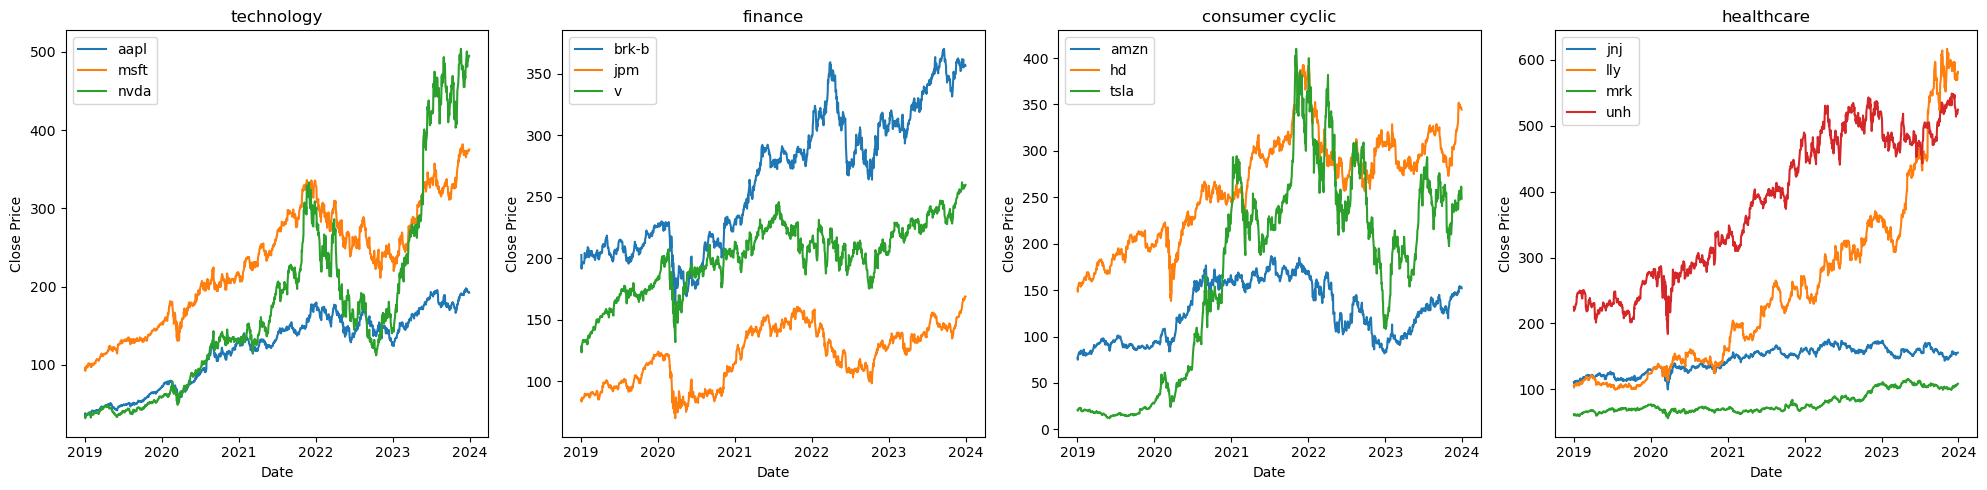

In [16]:
all_stocks = ["aapl", "amzn", "avgo", "brk-b", "cost", "hd", "jnj", "jpm", "lly", "ma", "meta", "mrk", "msft", "nvda", "pg", "tsla", "unh", "v", "xom"]
sectors = {
    "technology": ["aapl", "msft", "nvda"],
    "finance": ["brk-b", "jpm", "v"],
    "consumer cyclic": ["amzn", "hd", "tsla"],
    "healthcare": ["jnj", "lly", "mrk", "unh"]
}

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, (name, stocks) in enumerate(sectors.items()):
    for s in stocks:
        df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
        axs[i].plot(df.index, df['Close'], label=s)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Close Price')
    axs[i].legend()
    axs[i].set_title(name)
fig.tight_layout()
plt.show()


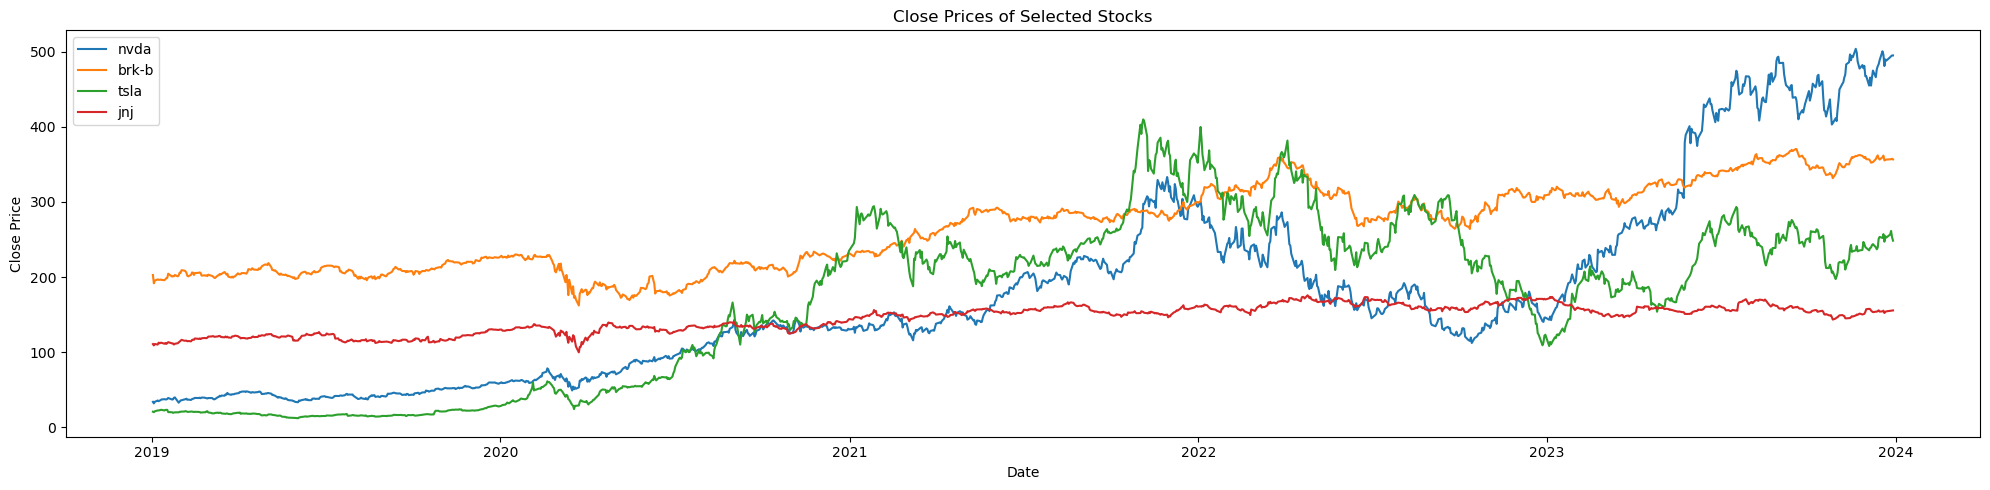

In [21]:
selected = ["nvda", "brk-b", "tsla", "jnj"]
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for s in selected:
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    ax.plot(df.index, df['Close'], label=s)
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
ax.set_title("Close Prices of Selected Stocks")
fig.tight_layout()
plt.show()

We should not use price as our target variable. Firstly, it is non-stationary. We want our model to be time invariant. Secondly, can't extrapolate. 

We don't care about level information. If our goal is to profit, we only care about the direction of the stock. Hence, using percentage change or returns would be more suitable.

In fact, we use log returns, because ...

Still non-constant variance, we have volatilty clustering. Some models like GARCH aim to model this.

The same logic applies to using return instead of price as our inputs.

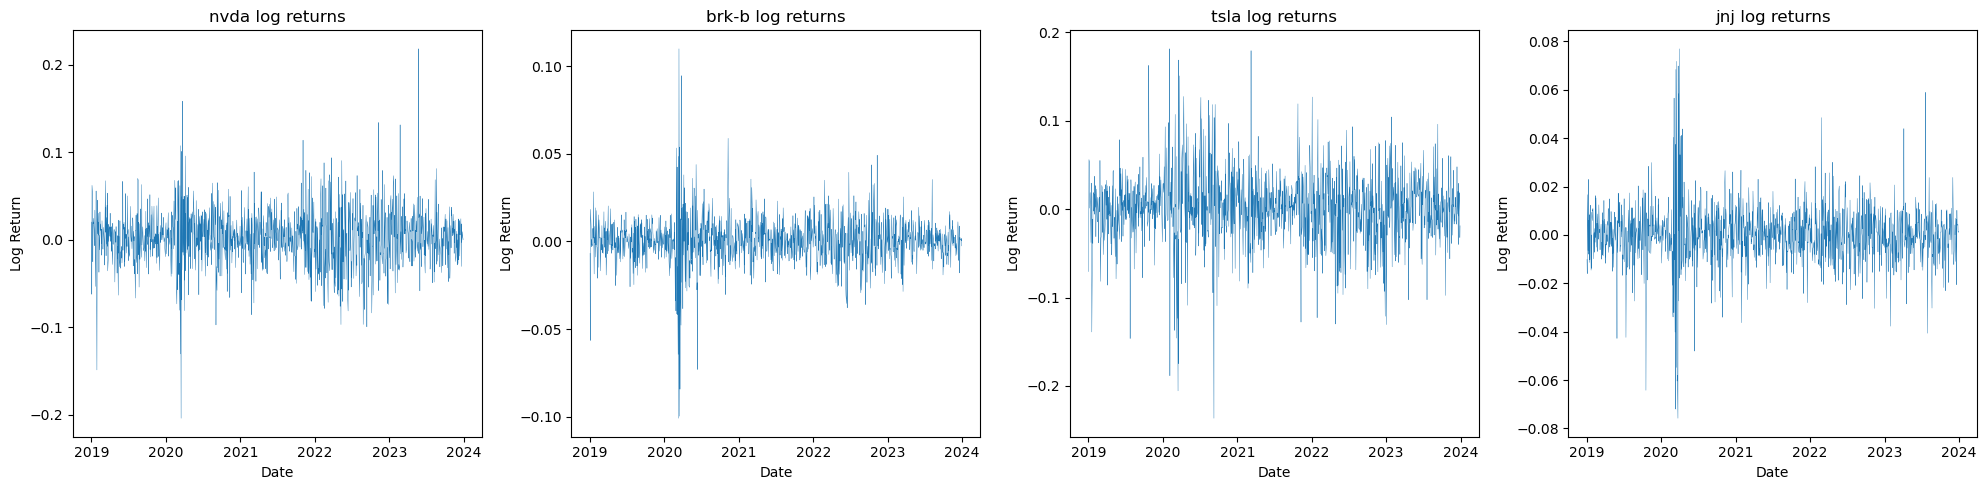

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    axs[i].plot(df.index, df['log_return'], label=s, linewidth=0.3)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Log Return')
    axs[i].set_title(f"{s} log returns")
fig.tight_layout()
plt.show()

For normalisation, we choose Z-score normalisation (standardisation) over Min-Max. Since normalisation only fitted to the training data to prevent data leakage, using min max constrains values to the range of the train set, even though our test data might very well have values above those in the train set.

/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/simon/anaconda3/envs/proj/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

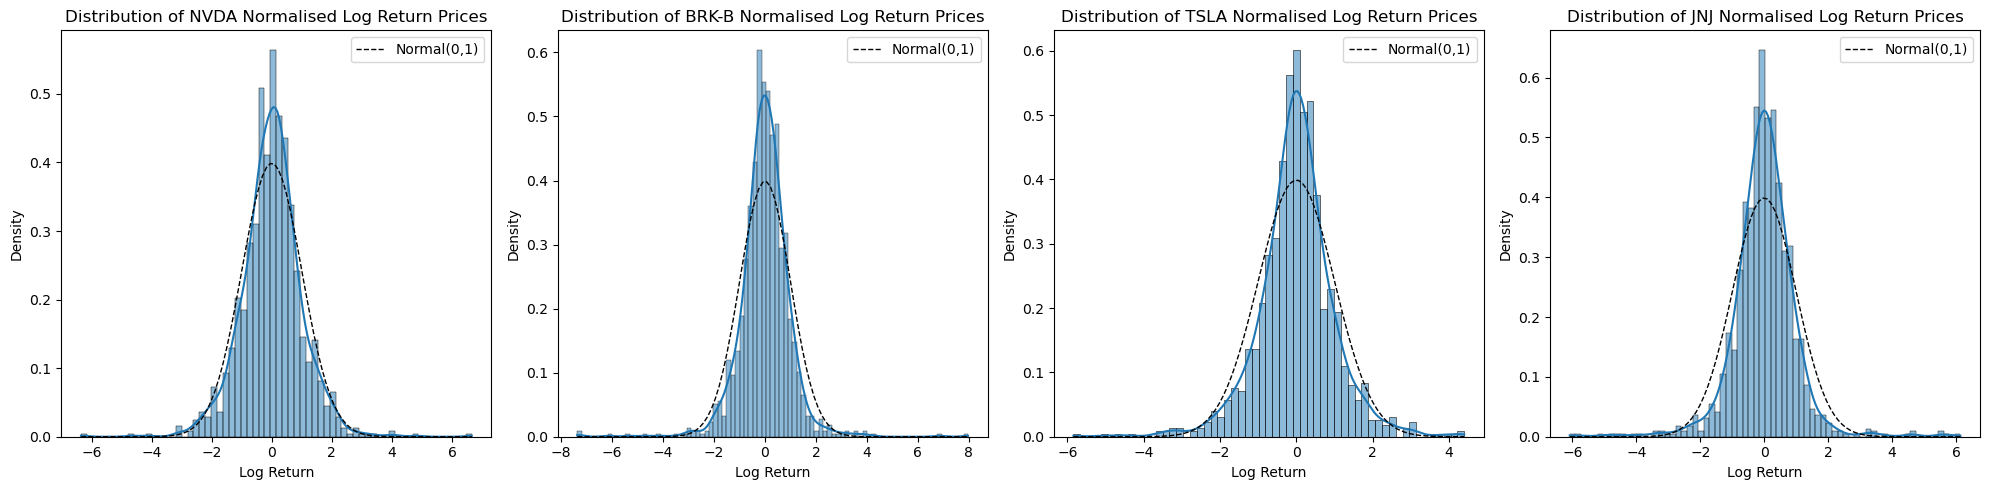

In [71]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")

    mean = df['log_return'].mean()
    std = df['log_return'].std()
    norm_log_return = (df['log_return'] - mean) / std
    # axs[i].hist(df['log_return'], bins=100, label=s)
    sns.histplot(norm_log_return, kde=True, ax=axs[i], stat="density")
    axs[i].set_title(f'Distribution of {s.upper()} Normalised Log Return Prices')
    axs[i].set_xlabel('Normalised Log Return')

    x = np.linspace(min(norm_log_return), max(norm_log_return), 100)
    p = stats.norm.pdf(x, 0, 1)
    axs[i].plot(x, p, 'k', linewidth=1, label=f'Normal(0,1)', linestyle="--")
    axs[i].legend()
fig.tight_layout()
plt.show()

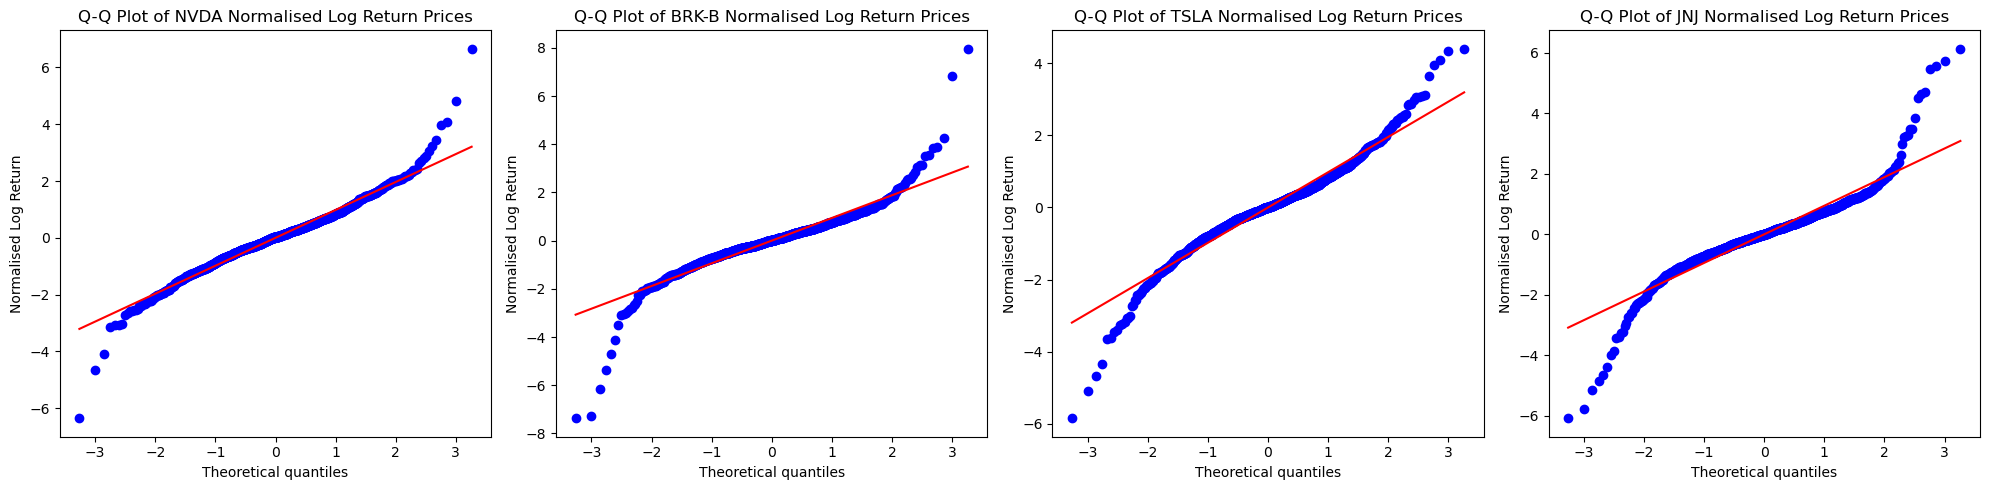

In [76]:
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
for i, s in enumerate(selected):
    df = load_processed_dataset(s, "2019-01-1", "2024-01-1")
    mean = df['log_return'].mean()
    std = df['log_return'].std()
    norm_log_return = (df['log_return'] - mean) / std
    # Q-Q plot
    stats.probplot(norm_log_return, dist="norm", plot=axs[i])
    axs[i].set_title(f'Q-Q Plot of {s.upper()} Normalised Log Return Prices')
    axs[i].set_ylabel('Normalised Log Return')
fig.tight_layout()
plt.show()

Although log return has many characterstics, being ...

It is not normally distributed. It has long tails. Using MSE loss means long tails will be penalised heavily much more than getting the middle of the distribution wrong. So our model will care about getting tail values rather than middle values. Therefore we use Huber loss because it is more lax on errors above a threshold. So we will set the threshold to 1, one standard deviation.

Carefully tuned SGD is better than Adam, so we use SGD. Also we use eight decay 1e-06.

Now we can look at R^2 metric to see if predictions are correlated.

Potential reasons for poor performance:
- Overfitting noisy data. Model finds mirage patterns.
- Not enough data. Trading minutes instead of days?
- Model does not have the right structure to extract insights.